In [1]:
import pandas as pd
import numpy as np

In [2]:
val_dataset_df = pd.read_csv("./coco-2014/dataset_csv/val_dataset.csv")
val_dataset_df.head()

,file_name,file_path,height,width,image_id,caption
0,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Two men wearing aprons working in a commercial...
1,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Chefs preparing food in a professional metalli...
2,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,Two people standing around in a large kitchen.
3,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,A commercial kitchen with two men working to p...
4,COCO_val2014_000000005802.jpg,/home/harsh/fiftyone/coco-2014/validation/data...,479,640,5802,two men in white shirts in a large steel kitchen


In [3]:
test_dataset_df = pd.read_csv('./coco-2014/dataset_csv/test_dataset.csv')
test_list_image_paths = np.random.choice(test_dataset_df['file_path'].values, size=20)
test_list_image_paths

array(['/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003081.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000004341.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000000870.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000004165.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000004944.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000005639.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000006163.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003887.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003636.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000004900.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000003496.jpg',
       '/home/harsh/fiftyone/coco-2014/test/data/COCO_test2014_000000000080.jpg',
       '/home/ha

In [4]:
val_list_image_paths = np.random.choice(val_dataset_df['file_path'].values, size=20)
val_list_image_paths

array(['/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000001347.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000001164.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000000564.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000005038.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000001228.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000006180.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000003794.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000005816.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000000776.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000001590.jpg',
       '/home/harsh/fiftyone/coco-2014/validation/data/COCO_val2014_000000005673.jpg',
       '/home/harsh/fiftyone/coco-2014/vali

# Inference and Evaluation

In [5]:
import os
import random
from argparse import ArgumentParser
import logging
import numpy as np

import torch
import pytorch_lightning as pl
from transformers import Dinov2Config

from dataset import InferenceDataset, load_image, SIZE
from model import (
    load_tokenizer,
    load_dinov2_image_encoder,
    load_lstm_text_encoder,
    load_show_and_tell,
    load_lightning_model,
)
from utils import (
    read_yaml,
    get_inference_dataset_config,
    get_image_model_config,
    get_tokenizer_config,
    get_text_model_config,
    get_model_config,
    get_inference_args,
    get_show_and_tell_model_config,
)


In [6]:
config = read_yaml("./configs/inference_config.yaml")

In [7]:
description, image_paths, dataset_config = get_inference_dataset_config(config)
dataset_config

{'return_dict': True, 'return_tensors': 'pt', 'image_size': [518, 518]}

In [8]:
inference_dataset = InferenceDataset(image_paths, **dataset_config)
inference_dataloader = torch.utils.data.DataLoader(inference_dataset, batch_size=1)
outs = next(iter(inference_dataloader))

In [9]:
tokenizer_name, tokenizer_path, tokenizer_config = get_tokenizer_config(config)
tokenizer = load_tokenizer(
    tokenizer_name=tokenizer_name,
    tokenizer_path=tokenizer_path,
    tokenizer_config=tokenizer_config,
)


In [10]:
# Initialize Models
model_config = get_model_config(config)

# Image encoder initialization
image_model_name, image_model_path, freeze, image_model_config = (
    get_image_model_config(model_config)
)
dinov2_config = Dinov2Config(**image_model_config)
image_encoder = load_dinov2_image_encoder(dinov2_config, freeze, image_model_path)

# Text encoder initialization
text_model_name, text_model_path, text_model_config = get_text_model_config(
    model_config
)
text_encoder = load_lstm_text_encoder(
    len(tokenizer), pretrained_model_path=text_model_path, **text_model_config
)

# Combined model initialization (Show and Tell)
showtell_core_model_name, showtell_core_model_path, showtell_core_config = (
    get_show_and_tell_model_config(model_config)
)
showtell_core = load_show_and_tell(
    tokenizer,
    image_encoder,
    text_encoder,
    pretrained_model_path=showtell_core_model_path,
)

# PyTorch Lightning model wrapper
model = load_lightning_model(tokenizer, showtell_core)

In [11]:
inference_args = get_inference_args(config)
inference_args

{'accelerator': 'gpu'}

In [12]:
trainer = pl.Trainer(**inference_args)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
predictions = trainer.predict(model, inference_dataloader)
captions = list(map(lambda x: x[0], predictions))

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

# Displaying Images and their captions

In [ ]:
"A cat is sitting on a bed with a window"

/tmp/ipykernel_25342/3815625233.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


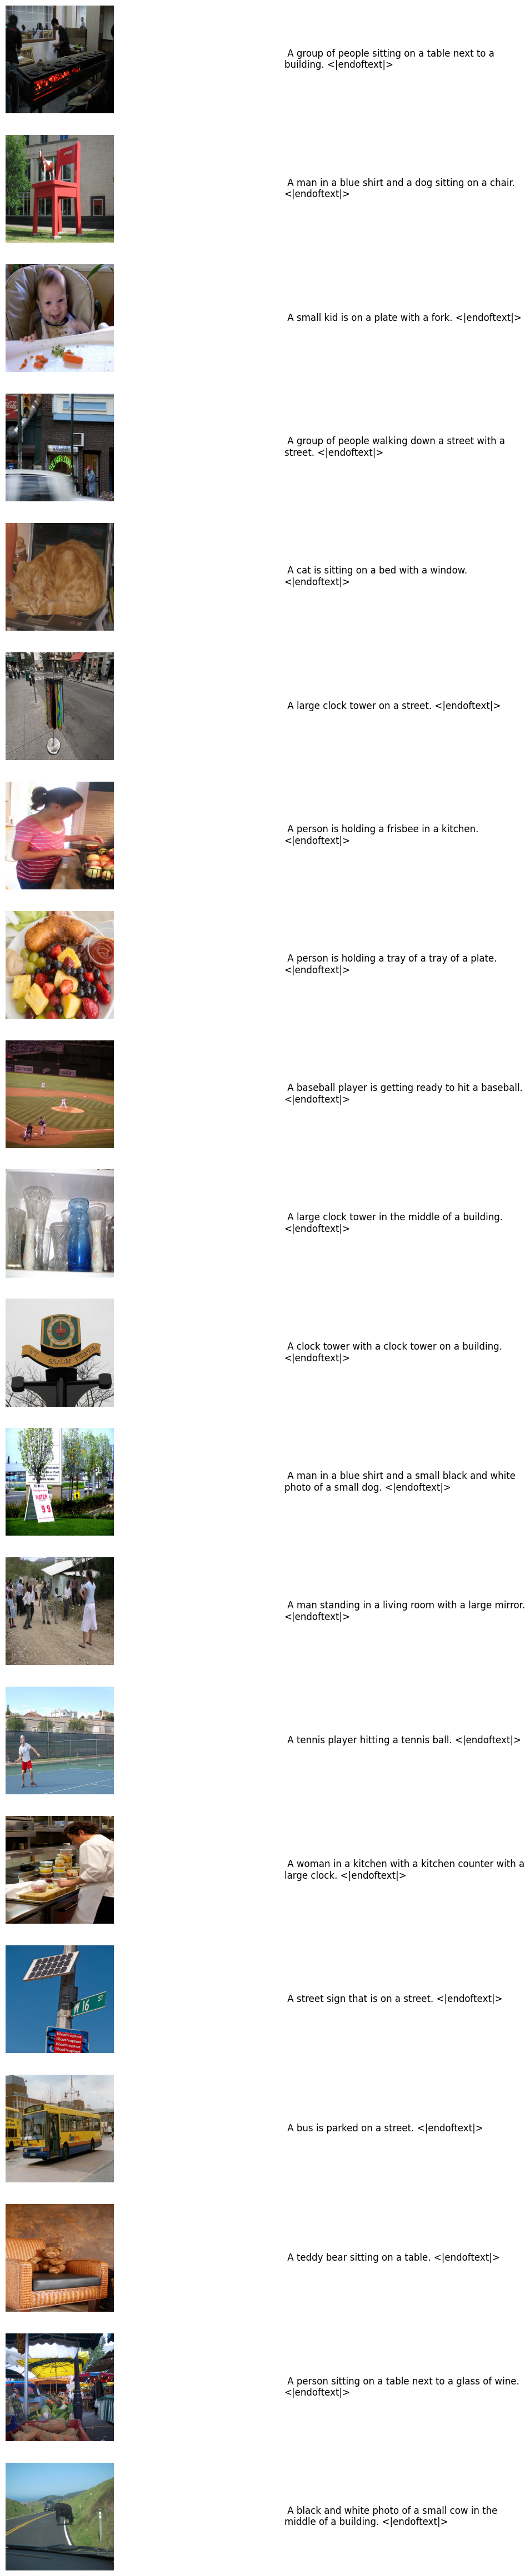

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def display_images_with_captions(image_paths, predictions, image_width=10, text_width=4):
    # Ensure we do not exceed the available images or predictions
    num_images = len(image_paths)

    # Dynamically adjust figure height based on the number of images
    fig_height = num_images * 3  # Scale height based on number of images
    fig = plt.figure(figsize=(image_width + text_width, fig_height))
    
    # Create a grid layout with minimal horizontal space
    grid = gridspec.GridSpec(num_images, 2, width_ratios=[image_width, text_width], wspace=0.05)

    for i in range(num_images):
        # Image subplot
        ax_image = plt.subplot(grid[i, 0])
        image = load_image(image_paths[i], size=dataset_config.get('image_size', SIZE), imagenet_normalize=False)
        ax_image.imshow(image)
        ax_image.axis("off")  # Hide axes for images

        # Text subplot
        ax_text = plt.subplot(grid[i, 1])
        ax_text.text(
            0, 0.5, predictions[i], fontsize=12, va='center', ha='left', wrap=True
        )
        ax_text.axis("off")  # Hide axes for text

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
display_images_with_captions(image_paths, captions)